Here we demonstrate the process of supervised learning using a dataset of temperature and formaldehyde values to classify ignition behavior into three classes (low-temperature ignition, high-temperature ignition, and no ignition). The data is preprocessed through normalization, then split into training, validation, and test sets to evaluate model performance. Two machine learning models—Support Vector Classifier (SVC) and Logistic Regression—are trained, and their hyperparameters are optimized using k-fold cross-validation. Accuracy is used as the performance metric, and the results are visualized through heatmaps and decision boundary plots to illustrate the effect of different parameter choices.
data : "data/adiabatic_1000_sk54.csv"

**Importing modules**

In [43]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr

import seaborn as sns

**Setup Matplotlib**

In [3]:
%matplotlib inline
plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]=12

colors=[(0,0.37,0.63), (0.863, 0.078, 0.235), (1, 0.84, 0)]
n_bins=3
cmap_name='my_list'
cmap=clr.LinearSegmentedColormap.from_list(cmap_name,colors,N=n_bins)

**Loading Data**

In [4]:
data=pd.read_csv("data/adiabatic_1000_sk54.csv")
print(data.head())
X=data[['T_0','X_fu']]
y=data['Label']
T_ad_K=data['T_ad_K']
CH2O=data['CH2O']


     T_0      X_fu      T_ad_K        Rho   AR             H             O  \
0  500.0  0.000000  500.000000  14.063690  0.0  0.000000e+00  8.930000e-41   
1  500.0  0.010101  500.000002  14.211226  0.0  5.210000e-31  1.960000e-27   
2  500.0  0.020202  500.000005  14.361154  0.0  1.330000e-30  2.270000e-27   
3  500.0  0.030303  500.000008  14.513534  0.0  2.280000e-30  2.520000e-27   
4  500.0  0.040404  500.000011  14.668426  0.0  3.310000e-30  2.680000e-27   

             OH           HO2            H2  ...      PXC12H25      SXC12H25  \
0  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
1  6.690000e-16  6.540000e-14  5.210000e-26  ...  4.340000e-20  1.940000e-19   
2  7.760000e-16  9.270000e-14  2.550000e-25  ...  1.020000e-19  4.530000e-19   
3  8.350000e-16  1.080000e-13  6.490000e-25  ...  1.660000e-19  7.390000e-19   
4  8.690000e-16  1.170000e-13  1.250000e-24  ...  2.330000e-19  1.040000e-18   

      S3XC12H25        C12H24      C12H25O2       

We plot the temperature and formaldehyde, which defines the low and high temperature ignition behavior in the 3 three classes (low T, high T, no ignition)

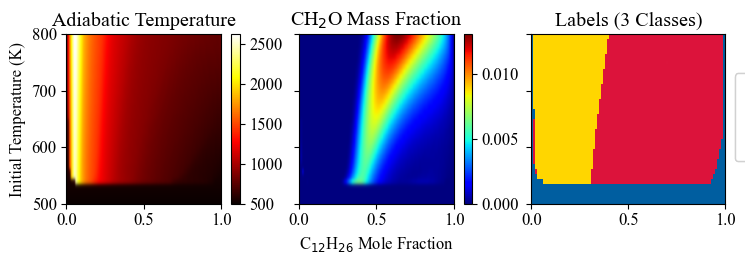

In [5]:
fig, axs= plt.subplots(1,3,figsize=(8.5,2.2),sharey=True)
image=axs[0].imshow(np.flipud(np.array(T_ad_K).reshape(34,100)),extent=[0,1,500,800],aspect='auto',interpolation='gaussian',cmap='hot')
axs[0].set_title('Adiabatic Temperature')
axs[0].set_ylabel('Initial Temperature (K)')
fig.colorbar(image, ax=axs[0])

image=axs[1].imshow(np.flipud(np.array(CH2O).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'gaussian',cmap = 'jet')
axs[1].set_title(r'CH$_2$O Mass Fraction')
axs[1].set_xlabel(r"C$_{12}$H$_{26}$ Mole Fraction")
fig.colorbar(image, ax=axs[1])

axs[2].imshow(np.flipud(np.array(y).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)
axs[2].set_title('Labels (3 Classes)')

my_scatter = axs[2].scatter([0,0.7,0.2],[500,750,750],c=[0,1,2],cmap=cmap,marker='.',s=12)
legend1 = axs[2].legend(*(my_scatter.legend_elements()[0],["No Ignition",r"Low $T$ Ignition",r"High $T$ Ignition"]),
                    loc=(1.05,0.25),ncol = 1,columnspacing=-0.2)
axs[2].add_artist(legend1)

**Train and Validation**

Now we split the dataset into training, validation (dev), and test sets. First, 60% of the data is set aside for training, while the remaining 40% is reserved. That 40% is then evenly divided into validation and test sets (20% each).

In [6]:
seed=42 
X_train, X_test_dev, y_train, y_test_dev = train_test_split(X, y, test_size=0.4, random_state=seed,stratify=y)
X_dev,X_test,y_dev,y_test=train_test_split(X_test_dev,y_test_dev,test_size=0.5,random_state=seed,stratify=y_test_dev)


Train=60.0 Dev=20.0 Test=20.0


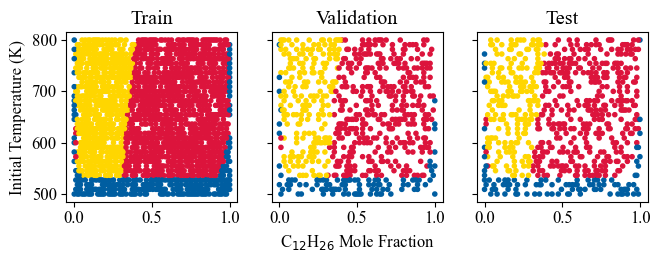

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.2), sharey=True)

axs[0].scatter(X_train.X_fu, X_train.T_0, c=y_train, cmap=cmap, marker='.')
axs[0].set_ylabel('Initial Temperature (K)')
axs[0].set_title('Train')

axs[1].scatter(X_dev.X_fu, X_dev.T_0, c=y_dev, cmap=cmap, marker='.')
axs[1].set_xlabel(r"C$_{12}$H$_{26}$ Mole Fraction")
axs[1].set_title('Validation')

axs[2].scatter(X_test.X_fu, X_test.T_0, c=y_test, cmap=cmap, marker='.')
axs[2].set_title('Test')

print("Train=" + str(len(y_train)/len(y)*100)+" Dev="+str(len(y_dev)/len(y)*100)+ " Test="+str(len(y_test)/len(y)*100))


The training set here will be used to fit the model. The test set will used to ensure that the trained model performs well on unseen data. The validation set acts as a test set in hyperparameter tuning.

We first normalize the dataset with a preprocessing function. This makes training easier for certain ML algortihms during gradient descent as all dimensions of the optimization manifold will be around the same scales.

In [8]:
X_train_scaled=preprocessing.StandardScaler().fit_transform(X_train)
X_dev_scaled=preprocessing.StandardScaler().fit_transform(X_dev)
X_test_scaled=preprocessing.StandardScaler().fit_transform(X_test)
X_decision_boundary=preprocessing.StandardScaler().fit_transform(X)

We use the accuracy score as performance metric to ensure that our hyperparameters of our ML model is tuned.

In [9]:
C_range=[1e-2,1e-1,1,10,1e2,1e3,1e4]
best_acc=-1
best_C=0
best_logReg=None
for C in C_range:
    logReg=LogisticRegression(C=C,random_state=seed).fit(X_train_scaled,y_train)
    y_train_pred=logReg.predict(X_train_scaled)
    y_dev_pred=logReg.predict(X_dev_scaled)
    train_acc=metrics.accuracy_score(y_train,y_train_pred)
    dev_acc=metrics.accuracy_score(y_dev,y_dev_pred)
    if dev_acc > best_acc:
        best_acc=dev_acc
        best_C=C
        best_logReg=logReg
print("The best C is %0.2f with an accuracy score of %0.5f"
      % (best_C, best_acc))

The best C is 1.00 with an accuracy score of 0.89265


In [10]:
y_test_pred=best_logReg.predict(X_test_scaled)
test_acc=metrics.accuracy_score(y_test,y_test_pred)
print("The test accuracy is ", test_acc)

The test accuracy is  0.8926470588235295


**Hyperparameter Search: SVC**

we introduce hyperparameter tuning via a k-fold cross-validation approach for our problem.

In [11]:
X_trainCV=X_dev
y_trainCV=y_dev 
X_trainCV_scaled=preprocessing.StandardScaler().fit_transform(X_trainCV)

In [12]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)

cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=seed)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_trainCV_scaled, y_trainCV)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': np.float64(10000.0), 'gamma': np.float64(0.1)} with a score of 0.98


We visualize the cross-validation accuracy of an SVM as a heatmap, showing how performance varies with different combinations of the hyperparameters.

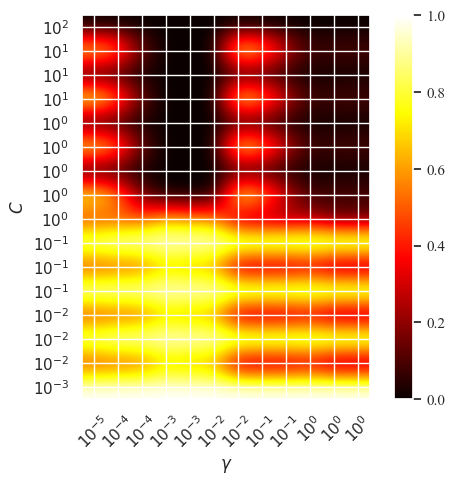

In [44]:
%matplotlib inline 

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range))
scores_normalized = MinMaxScaler().fit_transform(scores)

plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_normalized, interpolation='bicubic', cmap=plt.cm.hot, origin='lower')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$C$')
plt.colorbar()
plt.clim([0, 1])  

fmt_gamma = [r'$10^{%d}$' % np.log10(i) for i in gamma_range.tolist()]
fmt_C = [r'$10^{%d}$' % np.log10(i) for i in C_range.tolist()]

plt.xticks(np.arange(len(gamma_range)), fmt_gamma, rotation=45)  
plt.yticks(np.arange(len(C_range)), fmt_C)

plt.savefig("svm_validation.pdf", bbox_inches="tight")

We train SVM classifiers with four different combinations of 𝐶 and 𝛾 then we visualize their decision boundaries side by side. Each subplot shows how the model classifies ignition behavior across temperature and fuel fraction, with colors indicating different ignition classes.

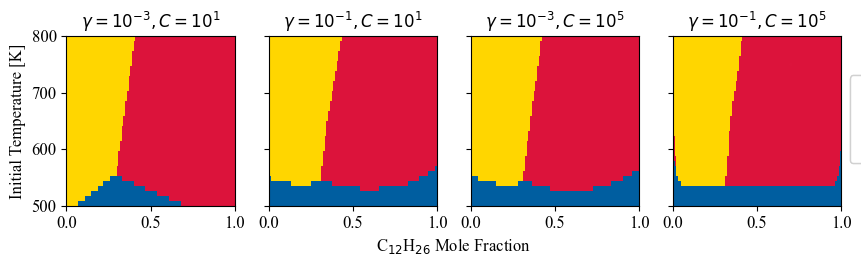

In [14]:

C_2d_range = [1e1, 1e5]
gamma_2d_range = [1e-3, 1e-1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_trainCV_scaled, y_trainCV)
        classifiers.append((C, gamma, clf))


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
fig, axs = plt.subplots(1, 4, figsize=(10, 2.2), sharey=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"C$_{12}$H$_{26}$ Mole Fraction")
axs[0].set_ylabel("Initial Temperature [K]")
for (k, (C, gamma, clf)) in enumerate(classifiers):
    
    axs[k].set_title(r"$\gamma=10^{%d} , C=10^%d$" % (np.log10(gamma), np.log10(C)),
              size='medium')
    axs[k].imshow(np.flipud(clf.predict(X_decision_boundary).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)
    

my_scatter = axs[3].scatter([0,0.7,0.2],[500,750,750],c=[0,1,2],cmap=cmap,marker='.',s=12)

legend1 = axs[3].legend(*(my_scatter.legend_elements()[0],["No Ignition",r"Low $T$ Ignitiozn",r"High $T$ Ignition"]),
                    loc=(1.05,0.25),ncol = 1,columnspacing=-0.2)
axs[3].add_artist(legend1)

**Hyperparameter search: Logistic regression** 

Now we perform hyperparameter tuning for Logistic Regression by testing different values of 𝐶 using grid search with stratified shuffle-split cross-validation. We fit the model on the training data, evaluate performance, and print the best 𝐶 value along with the corresponding cross-validation accuracy score.

In [15]:
C_range=[1e-2,1e-1,1,10,1e2,1e3,1e4]
param_grid=dict(C=C_range)
cv=StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=seed)
grid=GridSearchCV(LogisticRegression(), param_grid, cv=cv)
grid.fit(X_trainCV_scaled, y_trainCV)
print("The best parameters are ", grid.best_params_, " with a score of ", grid.best_score_)

The best parameters are  {'C': 100.0}  with a score of  0.875


**Hyperparameter search: Decision Tree**

We tune a Decision Tree classifier by performing grid search over different values of split size, leaf size, tree depth, and splitting criterion. Using stratified shuffle-split cross-validation, we evaluate the model with the macro F1-score, then report the combination of hyperparameters that yields the best performance.

In [16]:
param_grid = {
    'min_samples_split': [2, 5, 10, 20, 50, 100],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_depth': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy']
}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)
grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',  
    n_jobs=-1
)
grid.fit(X_trainCV_scaled, y_trainCV)
print("The best parameters are ", grid.best_params_, " with a score of ", grid.best_score_)

The best parameters are  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}  with a score of  0.972055919381902


**Hyperparameter search: Random Forests**

We perform hyperparameter optimization for a Random Forest classifier using randomized search. So we sample 50 random combinations of parameters (leaf size, number of trees, tree depth, feature selection method, and splitting criterion) from the defined grid, evaluate them with stratified shuffle-split cross-validation, and report the best parameter set along with its cross-validation score.

In [17]:
param_grid = {
    'min_samples_leaf': [2, 5, 10, 20, 50, 100],
    'n_estimators': [10, 20, 50],
    'max_depth': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)
random_search = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_grid,
    n_iter=50,  
    cv=cv,
    random_state=seed,
    n_jobs=-1
)
random_search.fit(X_trainCV_scaled, y_trainCV)
print("The best parameters are ", random_search.best_params_, " with a score of ", random_search.best_score_)

The best parameters are  {'n_estimators': 20, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'gini'}  with a score of  0.9720588235294118


**Benchmarking Classifiers**

Now we evaluate how different training set sizes affect the performance of several classifiers (Logistic Regression, Decision Tree, Random Forest, and SVM). For each training size, the data is split, scaled, and models are trained and tested on the same test set. The resulting accuracies are recorded for comparison, allowing analysis of how model performance scales with increasing amounts of training data.

In [18]:
train_size_list=[0.01,0.1,0.15,0.2,0.25,0.3,0.5]
logReg_i_list = []
dt_i_list = []
rf_i_list = []
mlp_i_list = []
svc_i_list = []

logReg_traintime_list = []
dt_traintime_list = []
rf_traintime_list = []
mlp_traintime_list = []
svc_traintime_list = []

logReg_testtime_list = []
dt_testtime_list = []
rf_testtime_list = []
mlp_testtime_list = []
svc_testtime_list = []

tmp_list = []

for train_size in train_size_list:
    X_train_i, Xtmp, y_train_i, ytmp = train_test_split(X_train, y_train, test_size=1.0-train_size, random_state=seed,stratify=y_train)

    X_scaled_i = preprocessing.scale(X_train_i)
    
    logReg = LogisticRegression(random_state=seed, C = 1000).fit(X_scaled_i, y_train_i)
    dt = DecisionTreeClassifier(random_state=seed,criterion = 'entropy').fit(X_scaled_i, y_train_i)
    rf = RandomForestClassifier(random_state=seed,n_estimators = 20,criterion = 'entropy').fit(X_scaled_i, y_train_i)    
    
    
    svc = SVC(gamma=0.1, C = 1e5, tol = 1e-4, kernel = 'rbf').fit(X_scaled_i, y_train_i)
    
    y_logReg_i = logReg.predict(X_test_scaled)
    y_dt_i = dt.predict(X_test_scaled)
    y_rf_i = rf.predict(X_test_scaled)
    y_svc_i = svc.predict(X_test_scaled)

    logReg_i_list.append(metrics.accuracy_score(y_test,y_logReg_i))
    dt_i_list.append(metrics.accuracy_score(y_test,y_dt_i))
    rf_i_list.append(metrics.accuracy_score(y_test,y_rf_i))
    svc_i_list.append(metrics.accuracy_score(y_test,y_svc_i))

Then we we plot learning curves for those four models, showing test accuracy versus training size.

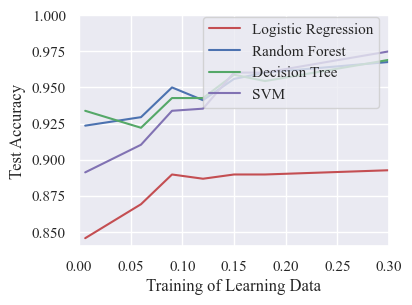

In [31]:
sns.set(style="darkgrid")
plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]=12
fig, axs = plt.subplots(1, 1, figsize=(4, 3))

plt.plot(np.array(train_size_list)*0.6, logReg_i_list,'r', label='Logistic Regression')
plt.plot(np.array(train_size_list)*0.6, dt_i_list,'b', label='Random Forest')
plt.plot(np.array(train_size_list)*0.6, rf_i_list,'g', label='Decision Tree')
plt.plot(np.array(train_size_list)*0.6, svc_i_list,'m', label='SVM') 

plt.xlim([0,0.3])
plt.ylim([0.84,1])

plt.legend(loc=[0.4,0.6])
plt.xlabel('Training of Learning Data')
plt.ylabel('Test Accuracy')

plt.savefig('learning_curves.png', format='pdf', bbox_inches='tight')


Here we see that most algorithms (except Logistic Regression) converge around accuracy of 0.97.
we compare computational cost during (training and predicting/inference) of the ML algorithms.

Now we train four classifiers on scaled data and record their fastest training and prediction times using %timeit

In [45]:
logReg = LogisticRegression(C = 1000).fit(X_scaled_i, y_train_i)
dt = DecisionTreeClassifier(criterion = 'entropy').fit(X_scaled_i, y_train_i)
rf = RandomForestClassifier(n_estimators = 20,criterion = 'entropy').fit(X_scaled_i, y_train_i)    
svc = SVC(gamma=0.1, C = 1e5, tol = 1e-4, kernel = 'rbf').fit(X_scaled_i, y_train_i)

my_time = %timeit -n 1 -r 3 -o  logReg
logReg_traintime=my_time.best

my_time = %timeit -n 1 -r 3 -o  dt
dt_traintime=my_time.best

my_time = %timeit -n 1 -r 3 -o  rf
rf_traintime=my_time.best

my_time = %timeit -n 1 -r 3 -o  svc
svc_traintime=my_time.best

print("--")
my_time = %timeit -n 1 -r 3 -o logReg.predict(X_test_scaled)
logReg_testtime = my_time.best 
my_time = %timeit -n 1 -r 3 -o dt.predict(X_test_scaled)
dt_testtime= my_time.best
my_time = %timeit -n 1 -r 3 -o rf.predict(X_test_scaled)
rf_testtime = my_time.best
my_time = %timeit -n 1 -r 3 -o svc.predict(X_test_scaled)
svc_testtime = my_time.best


567 ns ± 249 ns per loop (mean ± std. dev. of 3 runs, 1 loop each)
333 ns ± 125 ns per loop (mean ± std. dev. of 3 runs, 1 loop each)
300 ns ± 81.7 ns per loop (mean ± std. dev. of 3 runs, 1 loop each)
267 ns ± 170 ns per loop (mean ± std. dev. of 3 runs, 1 loop each)
--
The slowest run took 5.77 times longer than the fastest. This could mean that an intermediate result is being cached.
257 μs ± 187 μs per loop (mean ± std. dev. of 3 runs, 1 loop each)
138 μs ± 58.1 μs per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.42 ms ± 222 μs per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.37 ms ± 185 μs per loop (mean ± std. dev. of 3 runs, 1 loop each)


**Visualize Decision Boundaries: Setup**

In [ ]:
matplotlib.style.use('default') 

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12


X_train2, X_train58, y_train2, y_train58 = train_test_split(X_train, y_train, test_size=0.967, random_state=seed,stratify=y_train)
X_train20, X_train40, y_train20, y_train40 = train_test_split(X_train, y_train, test_size=0.667, random_state=seed,stratify=y_train)

X_scaled2 = preprocessing.scale(X_train2)
X_scaled20 = preprocessing.scale(X_train20)
X_scaled = preprocessing.scale(X_train)
X_train_list = [X_scaled2, X_scaled20,X_scaled] 
y_train_list = [y_train2, y_train20,y_train]

**Visualize Decision Boundaries: Logistic Regression**

We train and test logistic regression

In [22]:
logReg_list = []
y_logReg_decision_boundary_list = []
y_logReg_test_list = []
y_logReg_train_list = []
for i in range(len(X_train_list)):
    logReg_list.append(LogisticRegression(random_state=seed, C = 1000).fit(X_train_list[i], y_train_list[i]))
    y_logReg_decision_boundary_list.append(logReg_list[i].predict(X_decision_boundary))
    y_logReg_test_list.append(logReg_list[i].predict(X_test_scaled))
    y_logReg_train_list.append(logReg_list[i].predict(X_train_list[i]))


Now we compare predictions with the labels

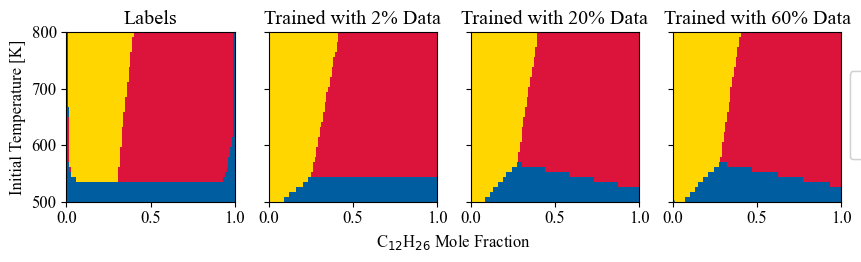

In [ ]:
%matplotlib inline 


fig, axs = plt.subplots(1, 4, figsize=(10, 2.2), sharey=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"C$_{12}$H$_{26}$ Mole Fraction")
axs[0].set_ylabel("Initial Temperature [K]")


axs[0].imshow(np.flipud(np.array(y).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)
for i in range(len(X_train_list)):
    axs[i+1].imshow(np.flipud(np.array(y_logReg_decision_boundary_list[i]).reshape(34,100)),extent=[0,1,500,800],aspect='auto',interpolation = 'none',cmap = cmap)

axs[0].set_title("Labels")
axs[1].set_title("Trained with 2% Data")
axs[2].set_title("Trained with 20% Data")
axs[3].set_title("Trained with 60% Data")

my_scatter = axs[3].scatter([0,0.7,0.2],[500,750,750],c=[0,1,2],cmap=cmap,marker='.',s=12)

legend1 = axs[3].legend(*(my_scatter.legend_elements()[0],["No Ignition",r"Low $T$ Ignition",r"High $T$ Ignition"]),loc=(1.05,0.25),ncol = 1,columnspacing=-0.2)
axs[3].add_artist(legend1)

**Visualize Decision Boundaries: Decision Tree**

We train Decision Tree classifiers on three different training set sizes (≈2%, 20%, 60%), predict their outputs on a decision boundary grid, test data, and training data, and visualize the results.

In [24]:
dt_list = []
y_dt_decision_boundary_list = []
y_dt_test_list = []
y_dt_train_list = []

for i in range(len(X_train_list)):
    dt_list.append(DecisionTreeClassifier(random_state=seed, criterion = 'entropy').fit(X_train_list[i], y_train_list[i]))
    y_dt_decision_boundary_list.append(dt_list[i].predict(X_decision_boundary))
    y_dt_test_list.append(dt_list[i].predict(X_test_scaled))
    y_dt_train_list.append(dt_list[i].predict(X_train_list[i]))

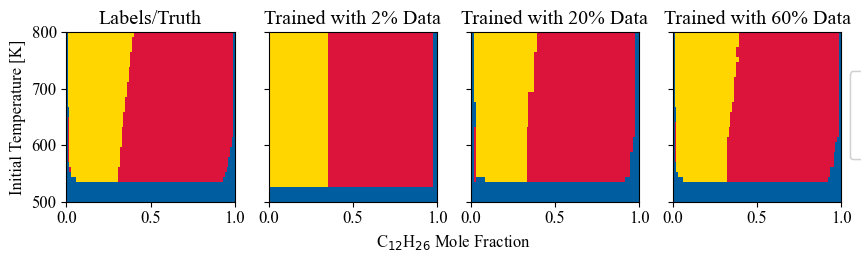

In [ ]:
%matplotlib inline 

fig, axs = plt.subplots(1, 4, figsize=(10, 2.2), sharey=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"C$_{12}$H$_{26}$ Mole Fraction")
axs[0].set_ylabel("Initial Temperature [K]")


axs[0].imshow(np.flipud(np.array(y).reshape(34,100)),extent=[0,1,500,800],aspect='auto',interpolation = 'none',cmap = cmap)
for i in range(len(X_train_list)):
    axs[i+1].imshow(np.flipud(np.array(y_dt_decision_boundary_list[i]).reshape(34,100)),extent=[0,1,500,800],aspect='auto',interpolation = 'none',cmap = cmap)
axs[0].set_title("Labels/Truth")
axs[1].set_title("Trained with 2% Data")
axs[2].set_title("Trained with 20% Data")
axs[3].set_title("Trained with 60% Data")

my_scatter = axs[3].scatter([0,0.7,0.2],[500,750,750],c=[0,1,2],cmap=cmap,marker='.',s=12)

legend1 = axs[3].legend(*(my_scatter.legend_elements()[0],["No Ignition",r"Low $T$ Ignition",r"High $T$ Ignition"]),loc=(1.05,0.25),ncol = 1,columnspacing=-0.2)
axs[3].add_artist(legend1)

**Visualize Decision Boundaries: SVC**

We train SVM classifiers with an RBF kernel on three different training set sizes (≈2%, 20%, 60%), predict their outputs on a decision boundary grid, test data, and training data, and visualize the results.

In [ ]:
svc_list = []
y_svc_decision_boundary_list = []
y_svc_test_list = []
y_svc_train_list = []

for i in range(len(X_train_list)):
    svc_list.append(SVC(gamma=0.1, C = 1e5, tol = 1e-4, kernel = 'rbf')
                    .fit(X_train_list[i], y_train_list[i]))
    y_svc_decision_boundary_list.append(svc_list[i].predict(X_decision_boundary))
    y_svc_test_list.append(svc_list[i].predict(X_test_scaled))
    y_svc_train_list.append(svc_list[i].predict(X_train_list[i]))

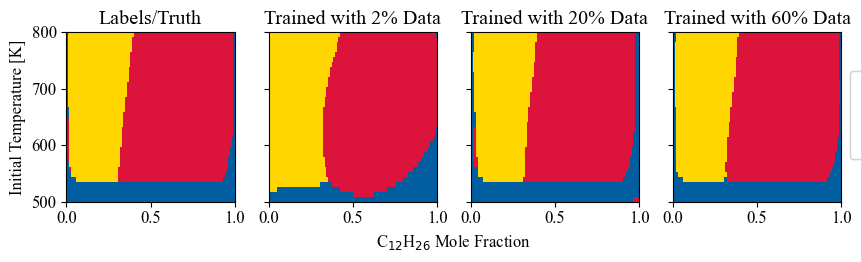

In [27]:
%matplotlib inline 
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
fig, axs = plt.subplots(1, 4, figsize=(10, 2.2), sharey=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"C$_{12}$H$_{26}$ Mole Fraction")
axs[0].set_ylabel("Initial Temperature [K]")

#Plot figure
axs[0].imshow(np.flipud(np.array(y).reshape(34,100)),extent=[0,1,500,800],aspect='auto',interpolation = 'none',cmap = cmap)
for i in range(len(X_train_list)):
    axs[i+1].imshow(np.flipud(np.array(y_svc_decision_boundary_list[i]).reshape(34,100)),extent=[0,1,500,800],aspect='auto',interpolation = 'none',cmap = cmap)
 
axs[0].set_title("Labels/Truth")
axs[1].set_title("Trained with 2% Data")
axs[2].set_title("Trained with 20% Data")
axs[3].set_title("Trained with 60% Data")

my_scatter = axs[3].scatter([0,0.7,0.2],[500,750,750],c=[0,1,2],cmap=cmap,marker='.',s=12)

legend1 = axs[3].legend(*(my_scatter.legend_elements()[0],["No Ignition",r"Low $T$ Ignition",r"High $T$ Ignition"]),loc=(1.05,0.25),ncol = 1,columnspacing=-0.2)
axs[3].add_artist(legend1)

**Visualize Decision Boundaries: Random Forest**

In [ ]:
rf_list = []
y_rf_decision_boundary_list = []
y_rf_test_list = []
y_rf_train_list = []

for i in range(len(X_train_list)):
    rf_list.append(RandomForestClassifier(random_state=seed,
    n_estimators = 20,
    criterion = 'entropy').fit(X_train_list[i], y_train_list[i]))
    y_rf_decision_boundary_list.append(rf_list[i].predict(X_decision_boundary))
    y_rf_test_list.append(rf_list[i].predict(X_test_scaled))
    y_rf_train_list.append(rf_list[i].predict(X_train_list[i]))

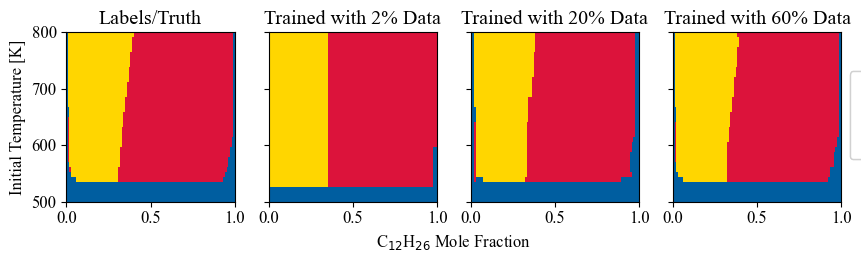

In [29]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2.2), sharey=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"C$_{12}$H$_{26}$ Mole Fraction")
axs[0].set_ylabel("Initial Temperature [K]")

axs[0].imshow(np.flipud(np.array(y).reshape(34,100)),extent=[0,1,500,800],aspect='auto',interpolation = 'none',cmap = cmap)
for i in range(len(X_train_list)):
    axs[i+1].imshow(np.flipud(np.array(y_rf_decision_boundary_list[i]).reshape(34,100)),extent=[0,1,500,800],aspect='auto',interpolation = 'none',cmap = cmap)

axs[0].set_title("Labels/Truth")
axs[1].set_title("Trained with 2% Data")
axs[2].set_title("Trained with 20% Data")
axs[3].set_title("Trained with 60% Data")

my_scatter = axs[3].scatter([0,0.7,0.2],[500,750,750],c=[0,1,2],cmap=cmap,marker='.',s=12)

legend1 = axs[3].legend(*(my_scatter.legend_elements()[0],["No Ignition",r"Low $T$ Ignition",r"High $T$ Ignition"]),loc=(1.05,0.25),ncol = 1,columnspacing=-0.2)
axs[3].add_artist(legend1)    

**Visualize Decision Boundaries: Putting it together**

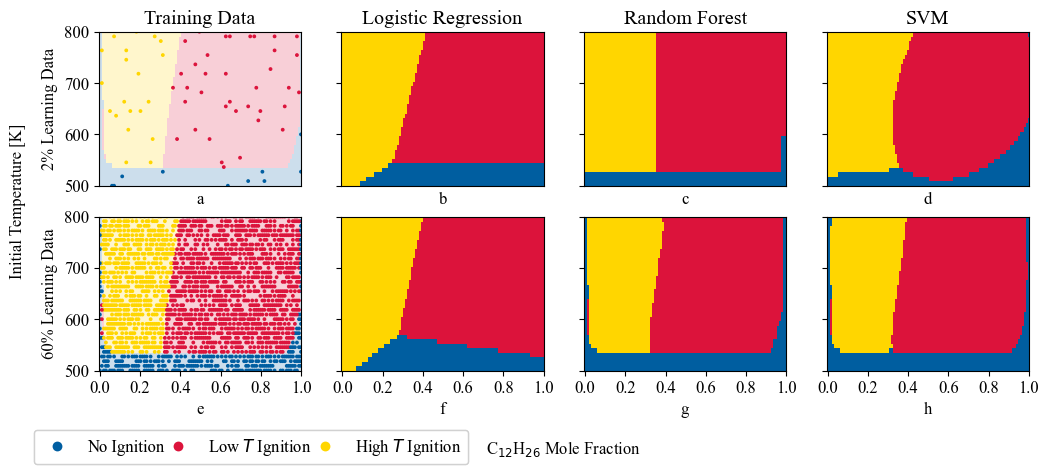

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(12, 4.4), sharey=True)  
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("\n\nC$_{12}$H$_{26}$ Mole Fraction")
plt.ylabel("Initial Temperature [K]\n\n")
axs[0, 0].set_ylabel("2% Learning Data")
axs[1, 0].set_ylabel("60% Learning Data")

axs[0, 0].imshow(np.flipud(np.array(y).reshape(34, 100)), extent=[0, 1, 500, 800], aspect='auto', interpolation='nearest', cmap=cmap, alpha=0.2)
axs[0, 0].set_title('Training Data')
axs[0, 0].set_xlabel('a')
my_scatter = axs[0, 0].scatter(X_train2.X_fu, X_train2.T_0, c=y_train2, cmap=cmap, marker='.', s=12)

legend1 = axs[1, 0].legend(*(my_scatter.legend_elements()[0], ["No Ignition", r"Low $T$ Ignition", r"High $T$ Ignition"]), loc=(-0.32, -0.61), ncol=3, columnspacing=-0.2)
axs[1, 0].add_artist(legend1)

axs[0, 1].imshow(np.flipud(np.array(y_logReg_decision_boundary_list[0]).reshape(34, 100)), extent=[0, 1, 500, 800], aspect='auto', interpolation='nearest', cmap=cmap)
axs[0, 1].set_xlabel('b')
axs[0, 1].set_title('Logistic Regression')

axs[0, 2].imshow(np.flipud(np.array(y_rf_decision_boundary_list[0]).reshape(34, 100)), extent=[0, 1, 500, 800], aspect='auto', interpolation='nearest', cmap=cmap)
axs[0, 2].set_xlabel('c')
axs[0, 2].set_title('Random Forest')

axs[0, 3].imshow(np.flipud(np.array(y_svc_decision_boundary_list[0]).reshape(34, 100)), extent=[0, 1, 500, 800], aspect='auto', interpolation='nearest', cmap=cmap)
axs[0, 3].set_xlabel('d')
axs[0, 3].set_title('SVM')

axs[1, 0].imshow(np.flipud(np.array(y).reshape(34, 100)), extent=[0, 1, 500, 800], aspect='auto', interpolation='nearest', cmap=cmap, alpha=0.2)
axs[1, 0].set_xlabel('e')
axs[1, 0].scatter(X_train.X_fu, X_train.T_0, c=y_train, cmap=cmap, marker='.', s=12)

axs[1, 1].imshow(np.flipud(np.array(y_logReg_decision_boundary_list[2]).reshape(34, 100)), extent=[0, 1, 500, 800], aspect='auto', interpolation='nearest', cmap=cmap)
axs[1, 1].set_xlabel('f')

axs[1, 2].imshow(np.flipud(np.array(y_rf_decision_boundary_list[2]).reshape(34, 100)), extent=[0, 1, 500, 800], aspect='auto', interpolation='nearest', cmap=cmap)
axs[1, 2].set_xlabel('g')

axs[1, 3].imshow(np.flipud(np.array(y_svc_decision_boundary_list[2]).reshape(34, 100)), extent=[0, 1, 500, 800], aspect='auto', interpolation='nearest', cmap=cmap)
axs[1, 3].set_xlabel('h')


for j in range(len(axs[0])):
    for i in range(len(axs)):
        axs[i, j].set_xlim([-0.005, 1.0])
    axs[0, j].set_xticks([])
    axs[1, j].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

fig.savefig("clf_decision_boundary.pdf", bbox_inches="tight")

All nonlinear classifiers(c,d) perform well when trained with 60% learning data, but demonstrate some flaws when trained with 2% learning data. For example, the sharp boundaries predicted by the random forest, in contrast to the smooth boundaries produced by SVMs , are artefacts of recursively partitioning the feature space during training. In many applications, decision trees and random forests can face issues when extrapolating outside of the training set due to this recursive partitioning; partitions for labels outside the training set are not well defined, which can result in clipped predictions. Logistic regression do not perform well with nonlinear problems without some sort of nonlinear transformation.